In [2]:
%reload_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

In [3]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

In [4]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x = '1.0 mm',
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=-1,loc_H=+1, pad_width='200um')
    )))

coupler = RouteStraight(design, 'coupler', Dict(hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='readout'),
            end_pin=Dict(component='Q2', pin='readout')), ))

gui.rebuild()
gui.autoscale()

In [5]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,...,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name,aedt_q3d_inductance,aedt_q3d_capacitance,aedt_hfss_inductance,aedt_hfss_capacitance
0,1,rect_jj,"LINESTRING (0 -0.015, 0 0.015)",1,False,False,main,0.02,10nH,0,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,1.000000e-08,0
1,2,rect_jj,"LINESTRING (1 -0.015, 1 0.015)",1,False,False,main,0.02,10nH,0,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,1.000000e-08,0


In [6]:
qcomps = design.components  # short handle (alias)
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
qcomps['Q2'].options['hfss_inductance'] = 'Lj2'
qcomps['Q2'].options['hfss_capacitance'] = 'Cj2'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

In [7]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_2qb = EPRanalysis(design, "hfss")

In [8]:
eig_2qb.sim.setup.max_passes = 15
eig_2qb.sim.setup.max_delta_f = 0.05
eig_2qb.sim.setup.n_modes = 2
eig_2qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF',
                           Lj2= '9 nH', Cj2= '0 fF')
eig_2qb.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 1,
 'n_modes': 2,
 'max_delta_f': 0.05,
 'max_passes': 15,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF', 'Lj2': '9 nH', 'Cj2': '0 fF'}}

In [9]:
# TODO: fold this inside either an analysis class method, or inside the analysis class setup

eig_2qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_2qb.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_2qb.sim.renderer.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'max_mesh_length_port': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.5,
 'y_buffer_width_mm': 0.5,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [10]:
eig_2qb.sim.run(name="TwoTransmons",
                components=['coupler', 'Q1', 'Q2'])

INFO 08:29AM [connect_project]: Connecting to Ansys Desktop API...
INFO 08:29AM [load_ansys_project]: 	Opened Ansys App
INFO 08:29AM [load_ansys_project]: 	Opened Ansys Desktop v2025.1.0
INFO 08:29AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Box/QuantumMetal/FourQubits/
	Project:   EPRAnalysis
INFO 08:29AM [connect_design]: 	Opened active design
	Design:    TransmonResonator_hfss [Solution type: Eigenmode]
INFO 08:29AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:29AM [connect]: 	Connected to project "EPRAnalysis" and design "TransmonResonator_hfss" 😀 

INFO 08:29AM [connect_design]: 	Opened active design
	Design:    TwoTransmons_hfss [Solution type: Eigenmode]
WARNING 08:29AM [connect_setup]: 	No design setup detected.
WARNING 08:29AM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:29AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:29AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.a

In [11]:
eig_2qb.sim.plot_convergences()

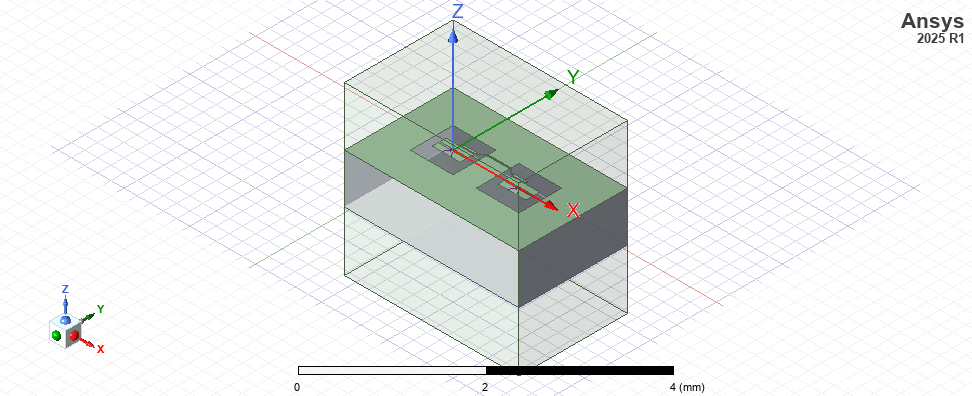

WindowsPath('D:/Box/QuantumMetal/FourQubits/ansys.png')

In [12]:
eig_2qb.sim.save_screenshot() 

In [13]:
eig_2qb.sim.plot_fields('main', eigenmode=2)

INFO 08:37AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


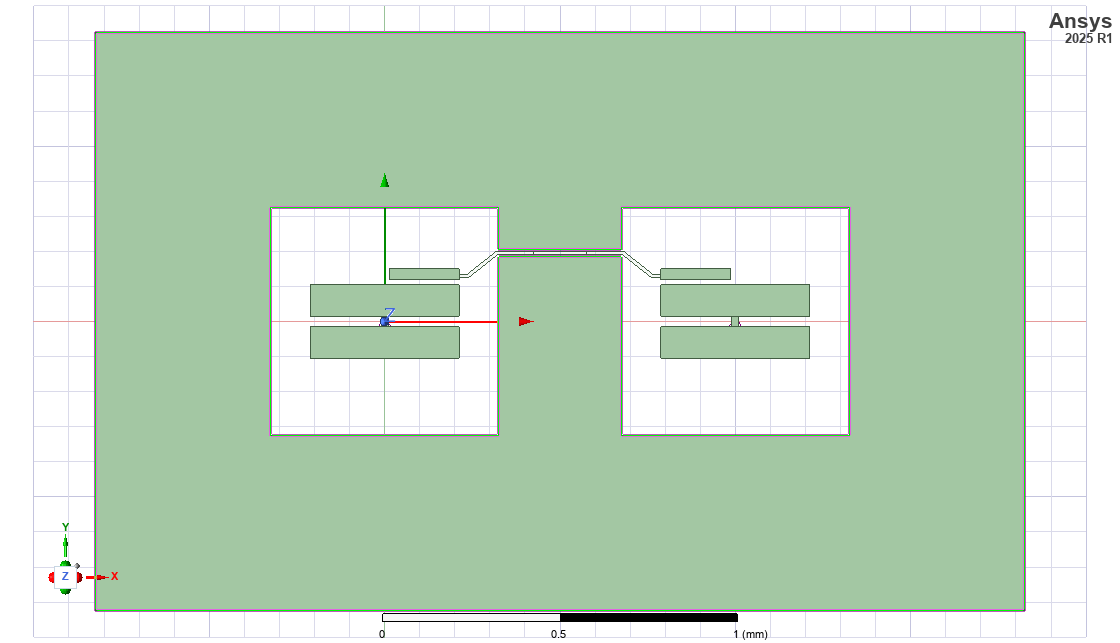

WindowsPath('D:/Box/QuantumMetal/FourQubits/ansys.png')

In [15]:
eig_2qb.sim.save_screenshot()

In [16]:
del eig_2qb.setup.junctions['jj']

In [17]:
eig_2qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                  Lj_variable='Lj1', Cj_variable='Cj1')
eig_2qb.setup.junctions.jj2 = Dict(rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_',
                  Lj_variable='Lj2', Cj_variable='Cj2')
eig_2qb.setup.sweep_variable = 'Lj1'
eig_2qb.setup

{'junctions': {'jj1': {'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_',
   'Lj_variable': 'Lj1',
   'Cj_variable': 'Cj1'},
  'jj2': {'rect': 'JJ_rect_Lj_Q2_rect_jj',
   'line': 'JJ_Lj_Q2_rect_jj_',
   'Lj_variable': 'Lj2',
   'Cj_variable': 'Cj2'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj1'}

In [18]:
eig_2qb.run_epr()

Design "TwoTransmons_hfss" info:
	# eigenmodes    2
	# variations    1
Design "TwoTransmons_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 4.26595731599942e-25
        energy_elec_substrate = 3.93196607234135e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.52633944277401e-27
        energy_mag % of energy_elec_all  = 0.6%
        

Variation 0  [1/1]

  Mode 0 at 5.62 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.6%  2.779e-25 1.117e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.86%
	jj1              0.99535  (+)        0.032281
		Energy fraction (Lj over Lj&Cj)= 97.80%
	jj2             0.000371601  (+)        8.34347e-06
		(U_tot_cap-U_tot_ind)/mean=1.60%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 

com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024382), None)

In [19]:
eig_2qb.sim.close()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [ ]:
gui.main_window.close()